In [14]:
#from envs.LinearBertrandInflation_final3 import LinearBertrandEnv
from envs.LinearBertrandInflation import LinearBertrandEnv
from envs.BertrandInflation import BertrandEnv
from agents.sac import SACAgent
from agents.ddpg import DDPGAgent
from replay_buffer import ReplayBuffer
from tqdm import tqdm
import numpy as np

N = 2
k = 10
rho = 2e-4
#total_timesteps = 30_000
total_timesteps = 150_000
episodes = 1
inflation_start = 0
deviate_start = 0.8
deviate_end = 0.95
trigger_deviate = False
lr = 1e-4

#env = LinearBertrandEnv(N = N, k = k, rho = rho, v = int(k * 1.5), timesteps = total_timesteps, moving_dim = 200, use_moving_avg=True, inflation_start=inflation_start, max_var = 2.0)
env = BertrandEnv(N = N, k = k, rho = rho, v = int(k * 1.5), timesteps = total_timesteps, 
                  use_moving_avg=True, inflation_start=inflation_start, max_var = 2.0)
dim_states = N * k + k + 1
agents = [SACAgent(dim_states, 1, gamma=0.95, actor_lr=lr, Q_lr=lr, alpha_lr=lr, use_epsilon_greedy=True, beta = 2e-5) for agent in range(env.N)]
#agents = [DDPGAgent(dim_states, 1, gamma=0.95, actor_lr=lr, Q_lr=lr) for agent in range(env.N)]

buffer = ReplayBuffer(dim_states=dim_states, N = env.N, sample_size = 512, buffer_size = 1_000_000)

prices_history = np.zeros((episodes, total_timesteps, N))
actions_history = np.zeros((episodes, total_timesteps, N))
costs_history = np.zeros((episodes, total_timesteps))
monopoly_history = np.zeros((episodes, total_timesteps))
nash_history = np.zeros((episodes, total_timesteps))
rewards_history = np.zeros((episodes, total_timesteps, N))
delta_history = np.zeros((episodes, total_timesteps))
quantities_history = np.zeros((episodes, total_timesteps, N))
pi_N_history = np.zeros((episodes, total_timesteps))
pi_M_history = np.zeros((episodes, total_timesteps))
A_history = np.zeros((episodes, total_timesteps))

for episode in range(episodes):
    ob_t = env.reset()
    for timestep in tqdm(range(total_timesteps)):
        
        actions = [agent.select_action(ob_t) for agent in agents]
        
        if trigger_deviate:
            if (timestep/total_timesteps > deviate_start) and (timestep/total_timesteps <= deviate_end):
                env.trigger_deviation = True
            
            elif timestep/total_timesteps > deviate_end:
                env.trigger_deviation = False
        
        ob_t1, rewards, done, _ = env.step(actions)
        
        experience = (ob_t, actions, rewards, ob_t1, done)
        buffer.store_transition(*experience)
        
        if timestep > buffer.sample_size:
            for agent_idx in range(N):
                agent = agents[agent_idx]
                sample = buffer.sample(agent_idx)
                agent.update(*sample)
        
        ob_t = ob_t1
        
    # store metrics
    prices_history[episode] = np.array(env.prices_history)[-total_timesteps:]
    actions_history[episode] = np.array(env.action_history)[-total_timesteps:]
    costs_history[episode] = np.array(env.costs_history)[-total_timesteps:]
    monopoly_history[episode] = np.array(env.monopoly_history)[-total_timesteps:]
    nash_history[episode] = np.array(env.nash_history)[-total_timesteps:]
    rewards_history[episode] = np.array(env.rewards_history)[-total_timesteps:]
    delta_history[episode] = np.array(env.metric_history)[-total_timesteps:]
    quantities_history[episode] = np.array(env.quantities_history)[-total_timesteps:]
    pi_N_history[episode] = np.array(env.pi_N_history)[-total_timesteps:]
    pi_M_history[episode] = np.array(env.pi_M_history)[-total_timesteps:]
    A_history[episode] = np.array(env.A_history)[-total_timesteps:]
    
prices_history = np.mean(prices_history, axis = 0)
actions_history = np.mean(actions_history, axis = 0)
costs_history = np.mean(costs_history, axis = 0)
monopoly_history = np.mean(monopoly_history, axis = 0)
nash_history = np.mean(nash_history, axis = 0)
rewards_history = np.mean(rewards_history, axis = 0)
delta_history = np.mean(delta_history, axis = 0)
quantities_history = np.mean(quantities_history, axis = 0)
pi_N_history = np.mean(pi_N_history, axis = 0)
pi_M_history = np.mean(pi_M_history, axis = 0)
A_history = np.mean(A_history, axis = 0) # equal disposition to pay

100%|██████████| 150000/150000 [1:18:25<00:00, 31.88it/s]


In [15]:
from utils.plot_metrics import get_rolling, get_rolling_std
import pandas as pd

## EXPORT
results = pd.DataFrame({'costs': costs_history,
                        'pi_N': pi_N_history,
                        'pi_M': pi_M_history,
                        'delta': delta_history,
                        'p_nash': nash_history,
                        'p_monopoly': monopoly_history,
                        'A': A_history,
                        })

for agent in range(env.N):
    results[f'actions_{agent}'] = actions_history[:, agent]
    results[f'prices_{agent}'] = prices_history[:, agent]
    results[f'quantities_{agent}'] = quantities_history[:, agent]
    results[f'rewards_{agent}'] = rewards_history[:, agent]
    
results.to_csv(f'test2.csv', index = False, sep = ';', encoding = 'utf-8-sig')

## READ AND PREPARE
window_size = 1000
df_avg = pd.DataFrame()
df_std = pd.DataFrame()

df_plot = pd.read_csv('test2.csv', sep = ';', encoding = 'utf-8-sig')

actions_cols = [col for col in df_plot.columns if 'actions' in col]
price_cols = [col for col in df_plot.columns if 'prices' in col]
rewards_cols = [col for col in df_plot.columns if 'rewards' in col]
quantities_cols = [col for col in df_plot.columns if 'quantities' in col]

n_agents = len(actions_cols)

df_plot['avg_actions'] = df_plot[actions_cols].mean(axis = 1)
df_plot['avg_prices'] = df_plot[price_cols].mean(axis = 1)
df_plot['avg_rewards'] = df_plot[rewards_cols].mean(axis = 1)
df_plot['avg_quantities'] = df_plot[quantities_cols].mean(axis = 1)
avg_cols = [col for col in df_plot.columns if 'avg' in col]

window_cols = price_cols + rewards_cols + quantities_cols + avg_cols + ['delta']
for col in window_cols:
    df_avg[col] = get_rolling(df_plot[col], window_size = window_size)
    df_std[col] = get_rolling_std(df_plot[col], window_size = window_size)

series_size = df_avg.shape[0]

df_plot.tail()

,costs,pi_N,pi_M,delta,p_nash,p_monopoly,A,actions_0,prices_0,quantities_0,rewards_0,actions_1,prices_1,quantities_1,rewards_1,avg_actions,avg_prices,avg_rewards,avg_quantities
149995,1.56672,0.299471,0.343706,0.825238,2.366191,2.754132,2.56672,0.372772,2.734779,0.336221,0.392726,0.461149,3.011703,0.193237,0.279225,0.416960,2.873241,0.335975,0.264729
149996,1.56672,0.299471,0.343706,0.819664,2.366191,2.754132,2.56672,0.371020,2.729291,0.339251,0.394404,0.462564,3.016137,0.191148,0.277053,0.416792,2.872714,0.335729,0.265200
149997,1.56672,0.299471,0.343706,0.820131,2.366191,2.754132,2.56672,0.370827,2.728685,0.339468,0.394450,0.462428,3.015711,0.191201,0.277049,0.416628,2.872198,0.335749,0.265335
149998,1.56672,0.299471,0.343706,0.807684,2.366191,2.754132,2.56672,0.370410,2.727377,0.341369,0.396212,0.465677,3.025892,0.187905,0.274185,0.418043,2.876634,0.335199,0.264637
149999,1.56672,0.299471,0.343706,0.808617,2.366191,2.754132,2.56672,0.370266,2.726926,0.341470,0.396176,0.465425,3.025102,0.188088,0.274304,0.417845,2.876014,0.335240,0.264779


In [13]:
import numpy as np

beta = 2e-5
count = 0
for t in range(100_000):
    
    random_number = np.random.rand()
    epsilon = np.exp(-t * beta)
    
    if random_number > epsilon:
        count += 1
        
count

56703

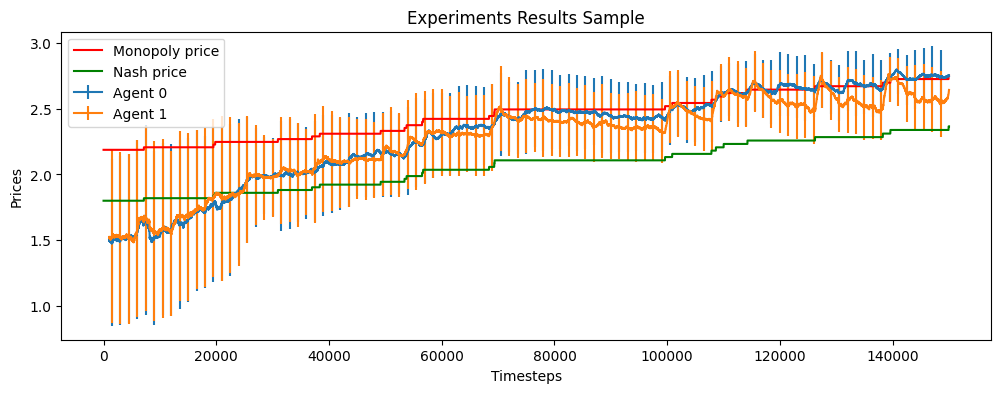

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))
for agent in range(n_agents):
    serie = f'prices_{agent}'
    #plt.plot(price_serie, label = f'Agent {agent}')
    plt.errorbar(range(series_size), df_avg[serie], df_std[serie], errorevery=int(0.01 * series_size), label = f'Agent {agent}')
plt.plot(df_plot['p_monopoly'], color = 'red', label = 'Monopoly price')
plt.plot(df_plot['p_nash'], color = 'green', label = 'Nash price')
plt.xlabel('Timesteps')
plt.ylabel('Prices')
plt.title('Experiments Results Sample')
plt.legend()
plt.savefig('prices.png')

Text(0.5, 1.0, 'Standard Deviation of Agent 0')

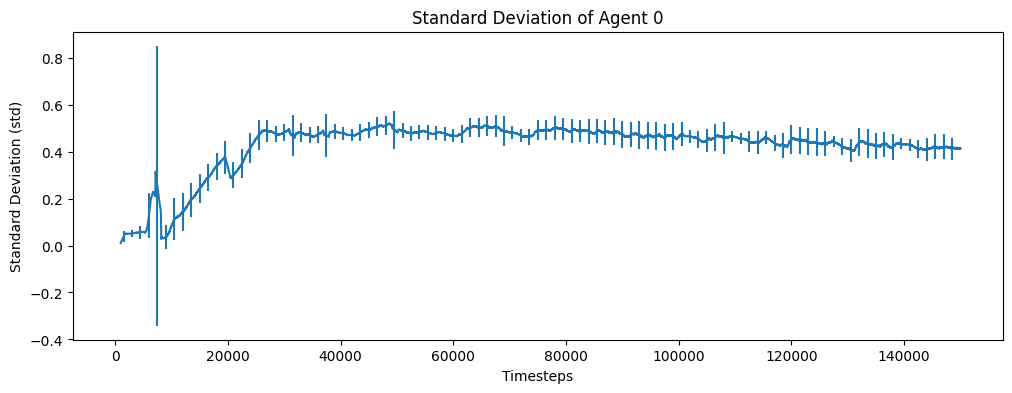

In [17]:
window_size = 1000
std_avg = get_rolling(agents[0].mean_history, window_size)
std_std = get_rolling_std(agents[0].mean_history, window_size)

std_size = len(std_std)

plt.figure(figsize = (12, 4))
plt.errorbar(range(std_size), std_avg, std_std, errorevery=int(0.01 * std_size))
plt.xlabel('Timesteps')
plt.ylabel('Standard Deviation (std)')
plt.title('Standard Deviation of Agent 0')
#plt.savefig('desviacion_estandar.png')

In [ ]:
window_size = 1000
std_avg = get_rolling(agents[0].std_history, window_size)
std_std = get_rolling_std(agents[0].std_history, window_size)

std_size = len(std_std)

plt.figure(figsize = (12, 4))
plt.errorbar(range(std_size), std_avg, std_std, errorevery=int(0.01 * std_size))
plt.xlabel('Timesteps')
plt.ylabel('Standard Deviation (std)')
plt.title('Standard Deviation of Agent 0')
#plt.savefig('desviacion_estandar.png')

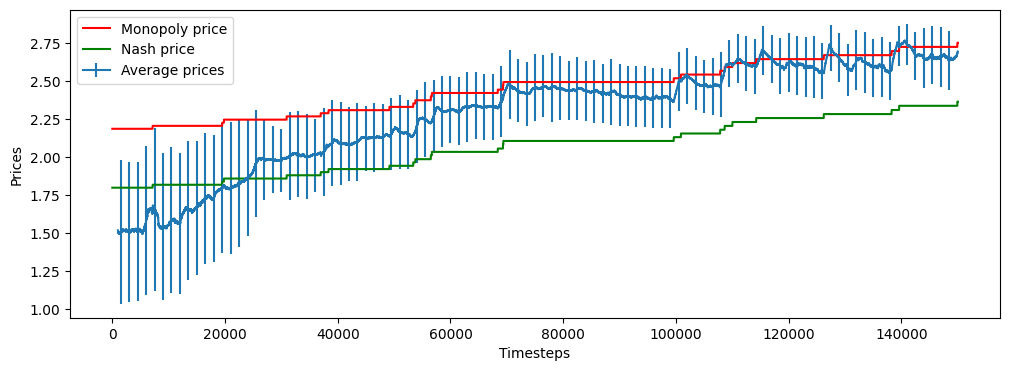

In [18]:
import matplotlib.pyplot as plt

size = len(df_avg[serie])
plt.figure(figsize = (12, 4))
#plt.plot(df_plot['avg_prices'], label = 'Average prices')
plt.errorbar(range(series_size), df_avg['avg_prices'], df_std['avg_prices'], errorevery=int(0.01 * series_size), label = f'Average prices')
plt.plot(df_plot['p_monopoly'], color = 'red', label = 'Monopoly price')
plt.plot(df_plot['p_nash'], color = 'green', label = 'Nash price')
plt.xlabel('Timesteps')
plt.ylabel('Prices')
plt.legend()
plt.savefig('plot.png')

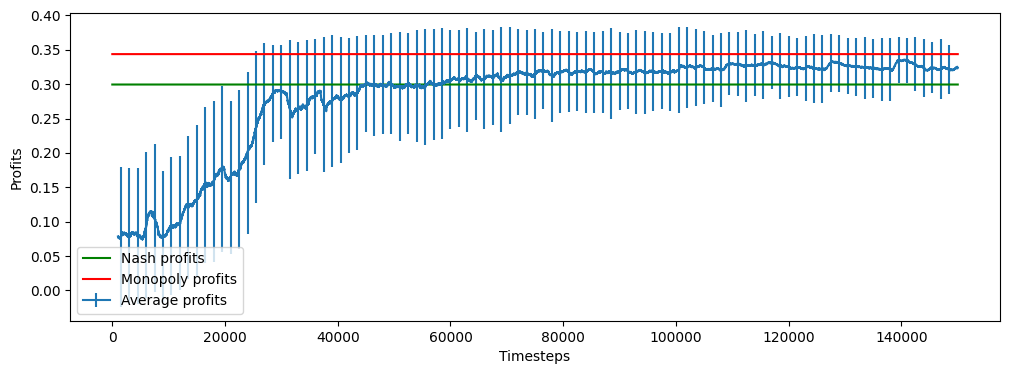

In [19]:
plt.figure(figsize = (12, 4))
#plt.plot(df_plot['avg_rewards'], label = 'Average profits')
plt.errorbar(range(series_size), df_avg['avg_rewards'], df_std['avg_rewards'], errorevery=int(0.01 * series_size), label = f'Average profits')
plt.plot(df_plot['pi_N'], label = 'Nash profits', color = 'green')
plt.plot(df_plot['pi_M'], label = 'Monopoly profits', color = 'red')
plt.xlabel('Timesteps')
plt.ylabel('Profits')
plt.legend()

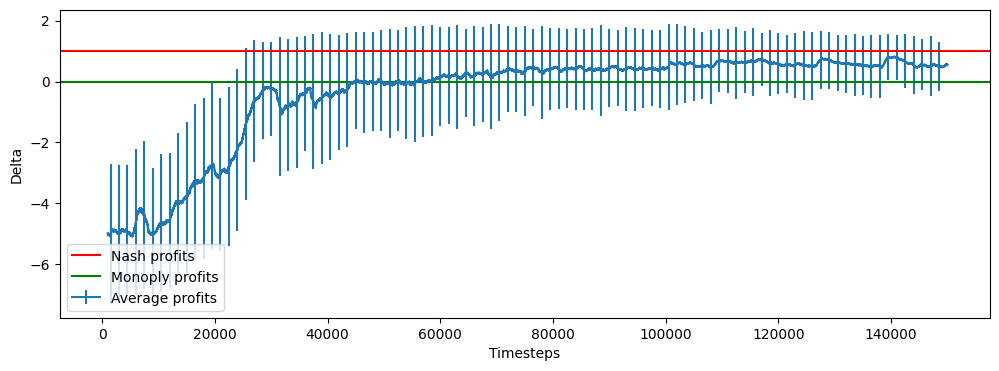

In [20]:
plt.figure(figsize = (12, 4))
#plt.plot(df_plot['delta'], label = 'Average profits')
plt.errorbar(range(series_size), df_avg['delta'], df_std['delta'], errorevery=int(0.01 * series_size), label = f'Average profits')
plt.axhline(1, color = 'red', label = 'Nash profits')
plt.axhline(0, color = 'green', label = 'Monoply profits')
plt.xlabel('Timesteps')
plt.ylabel('Delta')
plt.legend()

In [ ]:
import pandas as pd
import numpy as np

sample_size = 10

df  = pd.read_csv('test2.csv', sep = ';')
df = df.iloc[8000:8000 + sample_size]
df['rewards_0'] = df['rewards_0'].replace(0, np.nan)
df['rewards_1'] = df['rewards_1'].replace(0, np.nan)

df = df.dropna()
df

In [ ]:
import matplotlib.pyplot as plt
# Crea un histograma para la columna
plt.hist(df['prices_0'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precios')
plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt
# Crea un histograma para la columna
plt.hist(df['rewards_0'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Distribución de Recompensas')
plt.grid(True)

In [ ]:
rolling_df = df.rolling(10).mean().dropna()
rolling_df = rolling_df[['prices_0', 'p_nash', 'p_monopoly', 'rewards_0', 'pi_N', 'pi_M']]
rolling_df.head()